In [2]:
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
"""
1. Jyothi Vishnu Vardhan Kolla
2. Vidya Ganesh

Project-5: CS-5330-> Spring 2023.
"""

import torch
import torchvision
from torchvision import datasets


data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
    (0.1307, ), (0.3081,))
])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform,    
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

class_names = train_data.classes

In [4]:
print(class_names)
train_dataloader = DataLoader(train_data,
                                batch_size=32,
                                shuffle=True)

test_dataloader = DataLoader(test_data,
                            batch_size=32,
                            shuffle=False)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [5]:
train_dataloader

In [17]:
import torch
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
            in_channels=1,
            out_channels=10,
            kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(
            in_channels=10,
            out_channels=20,
            kernel_size=5,
            ),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=20 * 4 * 4, out_features=50),
            nn.Linear(50, 10)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return nn.functional.log_softmax(x)

    

In [18]:
model = LeNet().to(device="mps")

In [8]:
print(model)

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [19]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                             lr=0.1)

In [23]:
from helper_functions import accuracy_fn
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "mps"):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        #print(y_pred)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

for i in range(5):
    train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

/var/folders/qt/lcy0bl5s105cq2bn6m_hhzlc0000gn/T/ipykernel_38918/408714485.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


Train loss: 0.13944 | Train accuracy: 95.83%
Train loss: 0.11916 | Train accuracy: 96.48%
Train loss: 0.10596 | Train accuracy: 96.84%
Train loss: 0.10135 | Train accuracy: 96.96%
Train loss: 0.10107 | Train accuracy: 97.02%


In [4]:
dict_ = {'train_loss': [0.27054864591360095], 'train_acc': [91.66666666666667], 'test_loss': [0.07966596637933386], 'test_acc': [97.54392971246007]}
df = pd.DataFrame(dict_)
df

,train_loss,train_acc,test_loss,test_acc
0,0.270549,91.666667,0.079666,97.54393


In [6]:
import os
path = os.path.join("Models/results.csv")
df.to_csv(path)

In [20]:
df1 = pd.read_csv("Models/results.csv")
df1.head()

,Unnamed: 0,train_loss,train_acc,test_loss,test_acc
0,0,0.246825,92.501667,0.066225,97.753594
1,1,0.132994,96.013333,0.051816,98.342652
2,2,0.113442,96.655000,0.046505,98.492412
3,3,0.109930,96.701667,0.041878,98.722045
4,4,0.101617,96.945000,0.069096,97.743610


In [21]:
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1

,train_loss,train_acc,test_loss,test_acc
0,0.246825,92.501667,0.066225,97.753594
1,0.132994,96.013333,0.051816,98.342652
2,0.113442,96.655000,0.046505,98.492412
3,0.109930,96.701667,0.041878,98.722045
4,0.101617,96.945000,0.069096,97.743610


In [17]:
my_dict = df1.to_dict('list')
my_dict

NameError: name 'df1' is not defined

In [31]:
model_path = "Models/base_model.pth"
from models import LeNet
from dataloader import create_dataloaders

state_dict = torch.load(model_path, map_location=torch.device('mps'))
model = LeNet()
model.load_state_dict(state_dict)

train_data, test_data, class_names = create_dataloaders(32)


In [45]:
image, labels = next(iter(test_data))

In [71]:
torch.set_printoptions(precision=2)
model.eval()
pred_labels = []
with torch.inference_mode():
    for i in range(10):
        img = image[i].unsqueeze(0)
        label = labels[i]

        prediction = model(img)
        pred_labels.append(int(torch.argmax(prediction, dim=1)))
        print(f"Prediction Probabilities are: {prediction}")
        print(f"Original label:{label}, predicted label:{torch.argmax(prediction, dim=1)}")
        print("--------------------------------------------------------------------------")


Prediction Probabilities are: tensor([[-2.38e+01, -2.25e+01, -2.00e+01, -1.73e+01, -3.27e+01, -2.52e+01,
         -3.66e+01, -1.19e-07, -2.08e+01, -1.69e+01]])
Original label:7, predicted label:tensor([7])
--------------------------------------------------------------------------
Prediction Probabilities are: tensor([[-5.95e+00, -5.88e+00, -8.33e-03, -1.13e+01, -1.55e+01, -1.85e+01,
         -5.87e+00, -2.21e+01, -1.00e+01, -2.20e+01]])
Original label:2, predicted label:tensor([2])
--------------------------------------------------------------------------
Prediction Probabilities are: tensor([[-1.28e+01, -6.61e-04, -1.12e+01, -1.38e+01, -7.65e+00, -1.14e+01,
         -9.12e+00, -1.13e+01, -1.04e+01, -1.29e+01]])
Original label:1, predicted label:tensor([1])
--------------------------------------------------------------------------
Prediction Probabilities are: tensor([[-7.40e-05, -1.89e+01, -1.15e+01, -1.66e+01, -2.13e+01, -1.51e+01,
         -9.71e+00, -1.77e+01, -1.27e+01, -1.57e+01]

/Users/jyothivishnuvardhankolla/Desktop/Project-5-DeepNetworks/models.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


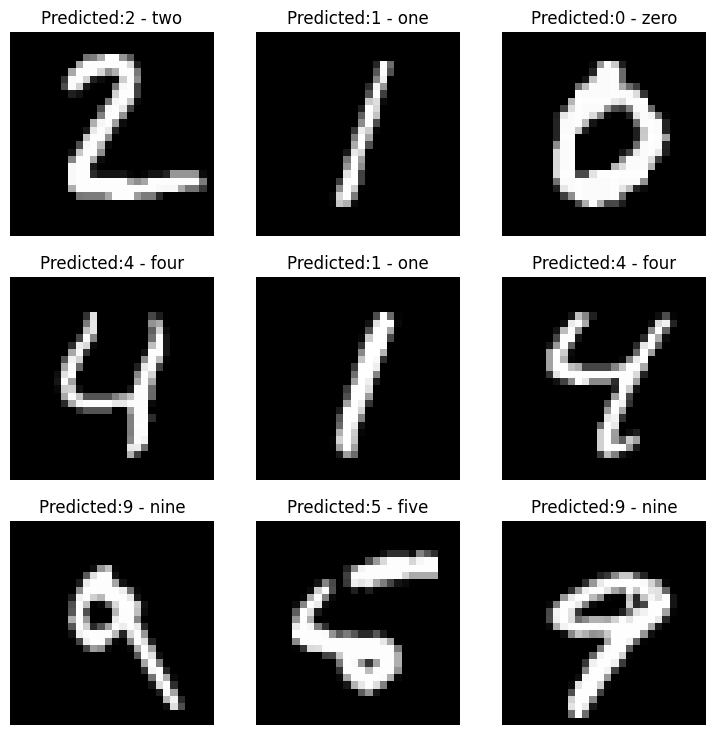

In [83]:
# Plot the predictions.
import matplotlib.pyplot as plt
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    img, label = image[i], labels[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted:{class_names[pred_labels[i]]}")
    plt.axis('off')

In [3]:
model_path = "Models/base_model.pth"
from models import LeNet
from dataloader import create_dataloaders

state_dict = torch.load(model_path, map_location=torch.device('mps'))
model = LeNet()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
for name, param in model.named_parameters():
    print(f"Layer Name: {name}")
    #print(f"Layer weights: {param}")

Layer Name: block_1.0.weight
Layer Name: block_1.0.bias
Layer Name: block_2.0.weight
Layer Name: block_2.0.bias
Layer Name: classifier.1.weight
Layer Name: classifier.1.bias
Layer Name: classifier.2.weight
Layer Name: classifier.2.bias


tensor([[-0.0696,  0.1216,  0.1264, -0.1283, -0.2596],
        [ 0.0454, -0.1114, -0.3396, -0.2346, -0.4654],
        [-0.1254, -0.1758, -0.1783, -0.1168, -0.0873],
        [-0.1665, -0.1705, -0.0270,  0.0532,  0.3247],
        [-0.4742, -0.1129, -0.0903,  0.2562,  0.3162]])


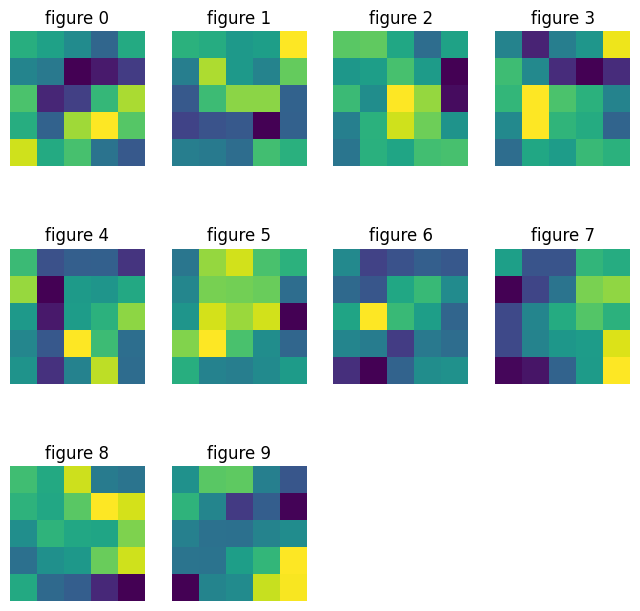

In [26]:
# Analyze the first layer.

import matplotlib.pyplot as plt
layer_name = "block_1.0.weight"
layer_weights = model.state_dict()[layer_name]
print(layer_weights[9][0])

fig = plt.figure(figsize=(8, 8))
rows,  cols = 3, 4
for i in range(1, rows * cols - 1):
    img = layer_weights[i - 1][0]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(f"figure {i - 1}")
    plt.axis('off')

plt.show()


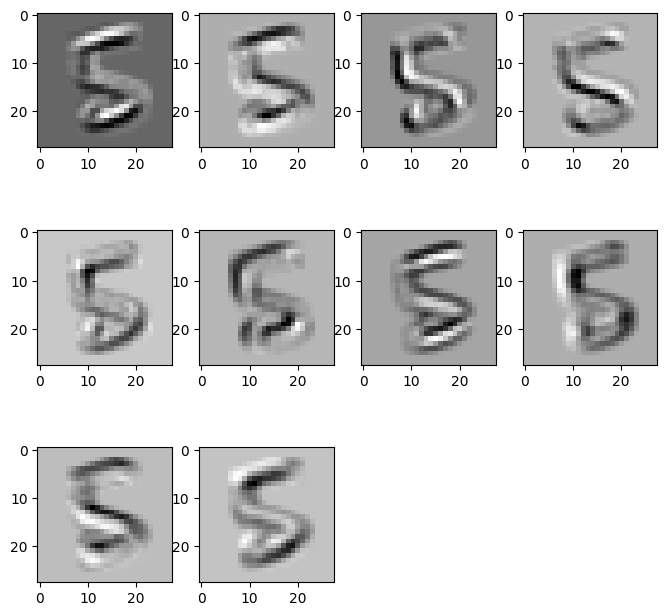

In [49]:
# Show the effect of the filters.
import cv2
from dataloader import create_dataloaders
train_data, test_data, class_names = create_dataloaders(32)

image, lable = next(iter(train_data))
image = image[0].numpy()

fig = plt.figure(figsize=(8, 8))
rows,  cols = 3, 4
for i in range(len(layer_weights)):
    kernel = layer_weights[i][0].numpy()
    filter_img = cv2.filter2D(image[0], -1, kernel)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(filter_img, cmap='gray')

plt.show()

In [54]:
import torch
from torchvision import transforms, datasets
import torchvision

class GreekTransform:
    def __init__(self):
        pass

    def __call__(self, x):
        x = torchvision.transforms.functional.rgb_to_grayscale( x )
        x = torchvision.transforms.functional.affine( x, 0, (0,0), 36/128, 0 )
        x = torchvision.transforms.functional.center_crop( x, (28, 28) )
        return torchvision.transforms.functional.invert( x )
    
# Define a transform to normalize the data.
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    GreekTransform(),
    torchvision.transforms.Normalize(
        (0.1307, ), (0.3081,))
])
    
# Dataloader for the greek dataset.
greek_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder("greek_train",
                                     transform=data_transform),
    batch_size=5,
    shuffle=True
)

In [55]:
# Load the previous model
device = torch.device("mps")
from models import LeNet
model_path = "Models/base_model.pth"
state_dict = torch.load(model_path, map_location=device)
model = LeNet()
model.load_state_dict(state_dict)

model.to(device=device)

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [56]:
for param in model.parameters():
    print(param.device)

mps:0
mps:0
mps:0
mps:0
mps:0
mps:0
mps:0
mps:0


In [58]:
from torchinfo import summary
summary(model, input_size=(1, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet (LeNet)                            [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (block_1)                   [1, 1, 28, 28]       [1, 10, 12, 12]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 10, 24, 24]      260                  True
│    └─MaxPool2d (1)                     [1, 10, 24, 24]      [1, 10, 12, 12]      --                   --
│    └─ReLU (2)                          [1, 10, 12, 12]      [1, 10, 12, 12]      --                   --
├─Sequential (block_2)                   [1, 10, 12, 12]      [1, 20, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 10, 12, 12]      [1, 20, 8, 8]        5,020                True
│    └─Dropout2d (1)                     [1, 20, 8, 8]        [1, 20, 8, 8]        --                   --
│    └─MaxPool2d (2)

In [59]:
for name, param in model.named_parameters():
    print(name, param.device)

block_1.0.weight cpu
block_1.0.bias cpu
block_2.0.weight cpu
block_2.0.bias cpu
classifier.1.weight cpu
classifier.1.bias cpu
classifier.2.weight cpu
classifier.2.bias cpu


In [61]:
for name, param in model.named_parameters():
    param.requires_grad = False

summary(model, input_size=(1, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet (LeNet)                            [1, 1, 28, 28]       [1, 10]              --                   False
├─Sequential (block_1)                   [1, 1, 28, 28]       [1, 10, 12, 12]      --                   False
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 10, 24, 24]      (260)                False
│    └─MaxPool2d (1)                     [1, 10, 24, 24]      [1, 10, 12, 12]      --                   --
│    └─ReLU (2)                          [1, 10, 12, 12]      [1, 10, 12, 12]      --                   --
├─Sequential (block_2)                   [1, 10, 12, 12]      [1, 20, 4, 4]        --                   False
│    └─Conv2d (0)                        [1, 10, 12, 12]      [1, 20, 8, 8]        (5,020)              False
│    └─Dropout2d (1)                     [1, 20, 8, 8]        [1, 20, 8, 8]        --                   --
│    └─MaxPool2

In [62]:
import torch
from torch import nn

model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=20 * 4 * 4, out_features=50),
    nn.Linear(50, 3)
).to(device=device)

summary(model, input_size=(1, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet (LeNet)                            [1, 1, 28, 28]       [1, 3]               --                   Partial
├─Sequential (block_1)                   [1, 1, 28, 28]       [1, 10, 12, 12]      --                   False
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 10, 24, 24]      (260)                False
│    └─MaxPool2d (1)                     [1, 10, 24, 24]      [1, 10, 12, 12]      --                   --
│    └─ReLU (2)                          [1, 10, 12, 12]      [1, 10, 12, 12]      --                   --
├─Sequential (block_2)                   [1, 10, 12, 12]      [1, 20, 4, 4]        --                   False
│    └─Conv2d (0)                        [1, 10, 12, 12]      [1, 20, 8, 8]        (5,020)              False
│    └─Dropout2d (1)                     [1, 20, 8, 8]        [1, 20, 8, 8]        --                   --
│    └─MaxPoo

In [63]:
for param in model.parameters():
    print(param.device)

cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu


In [74]:
model.to(device=device)
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=0.1)
for epoch in range(epochs):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(greek_train):
        X, y = X.to(device), y.to(device)
        #X, y = X.to(next(model.parameters()).dtype), y.to(next(model.parameters()).dtype)
        preds = model(X)

        loss = loss_fn(preds, y)
        train_loss += loss.item()

        # optimizer zero grad.
        optim.zero_grad()

        # Backpropagation.
        loss.backward()

        # optimizer step.
        optim.step()

        train_acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))

    train_loss /= len(greek_train)
    train_acc /= len(greek_train)

    print(train_loss, train_acc)



0.6509816547234853 90.0
0.5597625598311424 96.66666666666667
0.4752599497636159 88.33333333333333
0.5034506966670355 100.0
0.4476119776566823 91.66666666666667
0.39488616089026135 96.66666666666667
0.3382947084804376 100.0
0.3729604333639145 90.0
0.30817096928755444 100.0
0.29262369374434155 100.0


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

train_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=transforms.ToTensor(),
        target_transform=None
    )

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_dataloader = DataLoader(train_data,
                                batch_size=32,
                                shuffle=False)

test_dataloader = DataLoader(test_data,
                                batch_size=32,
                                shuffle=False)

class_names = train_data.classes

In [7]:
# Check the shape of image
image, label = next(iter(train_dataloader))
device = torch.device("mps")
print(image.shape)

torch.Size([32, 1, 28, 28])


In [12]:
from torch import nn
class tinyVgg(nn.Module):
    """
    Creates a tinyVgg type architecture to
    classify images in FashionMnist dataset.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.block1(x)
        print(x.shape)
        x = self.block2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        return x
    
torch.manual_seed(42)
model2 = tinyVgg(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model2

tinyVgg(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [13]:
sample_batch = image

model2.train()
model2(sample_batch.to(device))

torch.Size([32, 10, 14, 14])
torch.Size([32, 10, 7, 7])
torch.Size([32, 10])


tensor([[ 2.4593e-02, -6.4371e-02,  5.5120e-02, -3.6006e-02, -1.3872e-02,
          1.1296e-02, -1.4216e-03, -7.5383e-03,  2.1281e-02,  7.5776e-03],
        [ 4.0243e-02, -6.8717e-02,  5.4178e-02, -3.7612e-02, -9.1930e-04,
          2.0942e-02, -1.8477e-03, -1.9823e-02,  3.2062e-02,  2.2266e-03],
        [ 3.3069e-02, -5.8044e-02,  4.5893e-02, -2.7166e-02, -1.2846e-02,
          1.7892e-02, -6.3247e-03, -1.1802e-02,  3.0159e-02,  1.0959e-02],
        [ 3.4936e-02, -6.1729e-02,  4.9051e-02, -3.0888e-02, -8.9981e-03,
          1.7724e-02, -5.9958e-03, -1.4382e-02,  2.8959e-02,  7.0064e-03],
        [ 3.7249e-02, -6.6767e-02,  5.0417e-02, -3.7338e-02, -2.1710e-03,
          1.7135e-02,  1.8436e-04, -1.3679e-02,  2.9135e-02,  2.3956e-03],
        [ 3.8224e-02, -6.8479e-02,  5.9885e-02, -3.9917e-02, -8.5695e-03,
          2.0490e-02, -6.4659e-03, -1.0927e-02,  2.8594e-02,  3.9866e-03],
        [ 3.2211e-02, -6.4533e-02,  5.5958e-02, -2.4465e-02, -1.8215e-02,
          1.6885e-02, -4.2813e-0